In [ ]:
!pip install mglearn
!pip install spotipy

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import mglearn #library provided by amueller
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import time

In [ ]:
import spotipy 
sp = spotipy.Spotify() 
from spotipy.oauth2 import SpotifyClientCredentials 
import spotipy.util as util

In [ ]:
# setting up authorization
cid ="867dc132c2434968a7c7e7d1e25395ed" 
secret = "c675b70a26bb4f04a6eaab32fff5e350"

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
def getTrackIDs(user, playlist_id):
    ids = []
    playlist = sp.user_playlist(user, playlist_id)
    for item in playlist['tracks']['items']:
        track = item['track']
        ids.append(track['id'])
    return sorted(ids)

ids = getTrackIDs('d7b6075ffbda4d2d', '37i9dQZF1DWTwnEm1IYyoj') 
print(len(ids))

100


In [ ]:
def getTrackFeatures(id):
  meta = sp.track(id)
  features = sp.audio_features(id)

  # meta
  name = meta['name']
  album = meta['album']['name']
  artist = meta['album']['artists'][0]['name']
  release_date = meta['album']['release_date']
  length = meta['duration_ms']
  popularity = meta['popularity']

  # features
  acousticness = features[0]['acousticness']
  danceability = features[0]['danceability']
  energy = features[0]['energy']
  instrumentalness = features[0]['instrumentalness']
  liveness = features[0]['liveness']
  loudness = features[0]['loudness']
  speechiness = features[0]['speechiness']
  tempo = features[0]['tempo']
  time_signature = features[0]['time_signature']

  track = [name, album, artist, release_date, length, popularity, danceability, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo, time_signature]
  return track

In [ ]:
tracks = []
for i in range(len(ids)):
  time.sleep(.5)
  track = getTrackFeatures(ids[i])
  tracks.append(track)

# create dataset
df = pd.DataFrame(tracks, columns = ['name', 'album', 'artist', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'])


In [ ]:
df['release_date'] = df['release_date'].str[:4]

In [ ]:
df_prep = df.drop(['name', 'album', 'artist'], axis=1)
df_prep

,release_date,length,popularity,danceability,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,2019,174982,68,0.567,0.4560,0.567,0.696,0.0000,0.1130,-5.416,0.3010,92.061,4
1,2018,184732,82,0.753,0.1710,0.753,0.657,0.0000,0.1120,-3.061,0.0449,107.010,4
2,2008,191360,75,0.623,0.2960,0.623,0.417,0.0000,0.1350,-8.699,0.0354,130.032,4
3,2009,216666,1,0.675,0.2170,0.675,0.885,0.0000,0.0860,-4.432,0.0436,97.030,4
4,2007,237266,63,0.442,0.0456,0.442,0.793,0.0000,0.3280,-5.152,0.0347,80.985,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2017,233712,86,0.825,0.5810,0.825,0.652,0.0000,0.0931,-3.183,0.0802,95.977,4
96,2016,194453,66,0.667,0.4030,0.667,0.613,0.0000,0.1150,-5.353,0.0344,91.024,4
97,2001,249626,76,0.647,0.0206,0.647,0.729,0.0489,0.1340,-6.251,0.0236,94.010,4
98,2017,176320,70,0.728,0.4010,0.728,0.415,0.0000,0.0616,-6.852,0.0639,114.145,4


Population per class:       0
2019  20
2018  16
2008   3
2009   1
2007   5
2012   4
2014   7
2015   5
2017   9
2006   4
2011   3
2004   1
2001   2
2010   2
2013   4
2016   7
2005   3
2002   2
2003   1
2020   1
Proportion Chance Criterion: 9.76%
1.25 * Proportion Chance Criterion: 12.20%


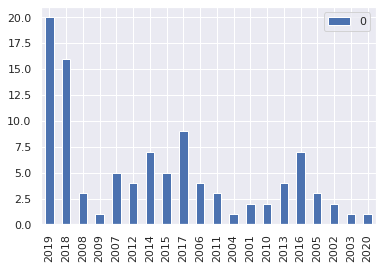

In [ ]:
from collections import Counter

def calculate_pcc():
  df = df_prep
  state_counts = Counter(df['release_date'])
  df_state = pd.DataFrame.from_dict(state_counts, orient='index')
  df_state.plot(kind='bar')

  num=(df_state[0]/df_state[0].sum())**2

  print("Population per class:{}".format(df_state))

  print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
  print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

calculate_pcc()

In [ ]:
def split_df():
  df = df_prep

  X = df.drop('release_date', axis = 1)
  y = df['release_date']

  return X, y

split_df()

(    length  popularity  danceability  ...  speechiness    tempo  time_signature
 0   174982          68         0.567  ...       0.3010   92.061               4
 1   184732          82         0.753  ...       0.0449  107.010               4
 2   191360          75         0.623  ...       0.0354  130.032               4
 3   216666           1         0.675  ...       0.0436   97.030               4
 4   237266          63         0.442  ...       0.0347   80.985               4
 ..     ...         ...           ...  ...          ...      ...             ...
 95  233712          86         0.825  ...       0.0802   95.977               4
 96  194453          66         0.667  ...       0.0344   91.024               4
 97  249626          76         0.647  ...       0.0236   94.010               4
 98  176320          70         0.728  ...       0.0639  114.145               4
 99  197293          78         0.612  ...       0.0347   77.002               4
 
 [100 rows x 12 columns], 

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
sns.pairplot(df_prep, hue = 'release_date')

ValueError: ignored

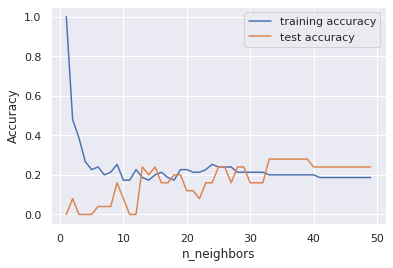

In [ ]:
from sklearn.model_selection import train_test_split

df = df_prep
X_train, X_test, y_train, y_test = train_test_split(df_prep,df['release_date'], 
                                                    test_size=0.25)

training_accuracy = []
test_accuracy = []
neighbors_settings = range(1, 50) # try n_neighbors from 1 to 50

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

pass